## Iteration 4 code
### Daorui Wang dwan266 796617373

In [1]:
# Initialize Spark
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')

# Standard Python libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# PySpark imports
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import coalesce, isnan, when, count, col, log1p, sqrt
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# PySpark ML imports
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import (LinearRegression, LinearRegressionModel, DecisionTreeRegressor, 
                                   RandomForestRegressor, GBTRegressor, AFTSurvivalRegression, 
                                   IsotonicRegression, FMRegressor, GeneralizedLinearRegression)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.linalg import Vectors

# Create Spark session
spark = SparkSession.builder.appName('HIV_Analysis').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/10 01:57:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### 1. Import data

In [2]:
deaths_data = spark.read.csv("no_of_deaths_by_country_clean.csv", header=True, inferSchema=True)
hiv_data = spark.read.csv("no_of_people_living_with_hiv_by_country_clean.csv", header=True, inferSchema=True)

# Rename the WHO Region column in the deaths_data dataset
deaths_data = deaths_data.withColumnRenamed("WHO Region", "WHO Region_deaths")

In [3]:
# Print the first five rows of the data so you can see the data structure
print("Deaths Data:")
print(deaths_data.head())

print("\nHIV Data:")
print(hiv_data.head())

Deaths Data:
Row(Country='Afghanistan', Year=2018, Count_deaths='500[200–610]', Count_median_deaths=500, Count_min_deaths=200, Count_max_deaths=610, WHO Region_deaths='Eastern Mediterranean')

HIV Data:
Row(Country='Afghanistan', Year=2018, Count_hiv='7200[4100–11000]', Count_median_hiv=7200, Count_min_hiv=4100, Count_max_hiv=11000, WHO Region='Eastern Mediterranean')


In [4]:
# View the data type 
print("\nDeaths Data Data Types:")
print(deaths_data.dtypes)

print("\nHIV Data Data Types:")
print(hiv_data.dtypes)


Deaths Data Data Types:
[('Country', 'string'), ('Year', 'int'), ('Count_deaths', 'string'), ('Count_median_deaths', 'int'), ('Count_min_deaths', 'int'), ('Count_max_deaths', 'int'), ('WHO Region_deaths', 'string')]

HIV Data Data Types:
[('Country', 'string'), ('Year', 'int'), ('Count_hiv', 'string'), ('Count_median_hiv', 'int'), ('Count_min_hiv', 'int'), ('Count_max_hiv', 'int'), ('WHO Region', 'string')]


In [7]:
deaths_data.describe().show()

+-------+-----------+------------------+--------------------+-------------------+------------------+------------------+-----------------+
|summary|    Country|              Year|        Count_deaths|Count_median_deaths|  Count_min_deaths|  Count_max_deaths|WHO Region_deaths|
+-------+-----------+------------------+--------------------+-------------------+------------------+------------------+-----------------+
|  count|        510|               510|                 510|                400|               400|               400|              510|
|   mean|       null|2009.3333333333333|                null|           6871.825|          5232.475|          9116.425|             null|
| stddev|       null| 7.370803835499056|                null| 17748.914144325325|13557.736617143164|24101.577969521568|             null|
|    min|Afghanistan|              2000|100000[68000–140000]|                100|               100|               100|           Africa|
|    max|   Zimbabwe|             

In [9]:
hiv_data.describe().show()

+-------+-----------+----------------+--------------------+------------------+------------------+------------------+---------------+
|summary|    Country|            Year|           Count_hiv|  Count_median_hiv|     Count_min_hiv|     Count_max_hiv|     WHO Region|
+-------+-----------+----------------+--------------------+------------------+------------------+------------------+---------------+
|  count|        680|             680|                 680|               553|               553|               553|            680|
|   mean|       null|         2008.25|                null|185791.82640144665|158800.48824593128|215200.83182640144|           null|
| stddev|       null|6.65226106820786|                null|  575675.030283062| 509382.2714220361| 643259.8874024194|           null|
|    min|Afghanistan|            2000|1000000[900000–11...|               100|               100|               100|         Africa|
|    max|   Zimbabwe|            2018|                  na|          

### 2. Merge and select data

In [5]:
merged_data = deaths_data.join(hiv_data, ["Country", "Year"], "outer")

# Select the columns we need and select the WHO Region_deaths column in deaths_data as the WHO Region column of the merged dataset
merged_data = merged_data.select('Country', 'Year', 'Count_deaths', 'Count_median_deaths', 'Count_hiv', 'Count_median_hiv', 'WHO Region','WHO Region_deaths')

merged_data = merged_data.withColumn("WHO Region", coalesce(merged_data["WHO Region_deaths"], merged_data["WHO Region"]))

merged_data = merged_data.drop("WHO Region_deaths")

In [6]:
merged_data.show()

+-----------+----+-----------------+-------------------+--------------------+----------------+--------------------+
|    Country|Year|     Count_deaths|Count_median_deaths|           Count_hiv|Count_median_hiv|          WHO Region|
+-----------+----+-----------------+-------------------+--------------------+----------------+--------------------+
|Afghanistan|2000|     100[100–500]|                100|     1600[1000–3500]|            1600|Eastern Mediterra...|
|Afghanistan|2005|             null|               null|     2900[1700–5000]|            2900|Eastern Mediterra...|
|Afghanistan|2010|     500[200–500]|                500|     4200[2500–6200]|            4200|Eastern Mediterra...|
|Afghanistan|2018|     500[200–610]|                500|    7200[4100–11000]|            7200|Eastern Mediterra...|
|    Albania|2000|               na|               null|                  na|            null|              Europe|
|    Albania|2005|             null|               null|                

#### 2.1. Show the data quality

In [7]:
# View basic information of the data
print("Total rows:", merged_data.count())
print("Total columns:", len(merged_data.columns))
print("Column information:")
merged_data.printSchema()

# Check for missing values
print("Missing values for each column:")
merged_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in merged_data.columns]).show()

# View statistics
print("Statistical Information:")
merged_data.describe().show()

Total rows: 680
Total columns: 7
Column information:
root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Count_deaths: string (nullable = true)
 |-- Count_median_deaths: integer (nullable = true)
 |-- Count_hiv: string (nullable = true)
 |-- Count_median_hiv: integer (nullable = true)
 |-- WHO Region: string (nullable = true)

Missing values for each column:
+-------+----+------------+-------------------+---------+----------------+----------+
|Country|Year|Count_deaths|Count_median_deaths|Count_hiv|Count_median_hiv|WHO Region|
+-------+----+------------+-------------------+---------+----------------+----------+
|      0|   0|         170|                280|        0|             127|         0|
+-------+----+------------+-------------------+---------+----------------+----------+

Statistical Information:
+-------+-----------+----------------+--------------------+-------------------+--------------------+------------------+---------------+
|summary|    

### 3.Clean the data (Missing value)

#### 3.1. Populate values for Count_median_deaths column for 2005 for each country

In [8]:
# Calculate the average of Count_median_deaths for the years 2000 and 2010 for each country
avg_window = Window.partitionBy("Country")
average_values = merged_data.withColumn("Avg_2000_2010", 
                                        F.when((F.col("Year") == 2000) | (F.col("Year") == 2010), F.col("Count_median_deaths"))
                                         .otherwise(None))\
                            .withColumn("Avg_2000_2010", F.avg("Avg_2000_2010").over(avg_window))

# Fill the 2005 values for Count_median_deaths with the calculated average for each country
filled_data = average_values.withColumn("Count_median_deaths",
                                        F.when((F.col("Year") == 2005) & (F.col("Count_median_deaths").isNull()), F.col("Avg_2000_2010"))
                                         .otherwise(F.col("Count_median_deaths")))

# Drop the auxiliary column
filled_data = filled_data.drop("Avg_2000_2010")

# Display the filled data for 2005
filled_data.filter(filled_data['Year'] == 2005).select('Country', 'Year', 'Count_median_deaths').show()

+--------------------+----+-------------------+
|             Country|Year|Count_median_deaths|
+--------------------+----+-------------------+
|         Afghanistan|2005|              300.0|
|             Albania|2005|               null|
|             Algeria|2005|              150.0|
|              Angola|2005|             7400.0|
|           Argentina|2005|             1500.0|
|             Armenia|2005|              150.0|
|           Australia|2005|              500.0|
|             Austria|2005|               null|
|          Azerbaijan|2005|               null|
|             Bahamas|2005|              350.0|
|             Bahrain|2005|               null|
|          Bangladesh|2005|              300.0|
|            Barbados|2005|              100.0|
|             Belarus|2005|              150.0|
|             Belgium|2005|               null|
|              Belize|2005|              150.0|
|               Benin|2005|             2200.0|
|              Bhutan|2005|             

#### 3.2. Delete rows containing NaN values

In [9]:
# Drop rows with NaN values
filtered_data = filled_data.dropna()

# Display the result
filtered_data.show()

+-----------+----+-----------------+-------------------+--------------------+----------------+--------------------+
|    Country|Year|     Count_deaths|Count_median_deaths|           Count_hiv|Count_median_hiv|          WHO Region|
+-----------+----+-----------------+-------------------+--------------------+----------------+--------------------+
|Afghanistan|2000|     100[100–500]|              100.0|     1600[1000–3500]|            1600|Eastern Mediterra...|
|Afghanistan|2010|     500[200–500]|              500.0|     4200[2500–6200]|            4200|Eastern Mediterra...|
|Afghanistan|2018|     500[200–610]|              500.0|    7200[4100–11000]|            7200|Eastern Mediterra...|
|    Algeria|2000|     100[100–100]|              100.0|     1900[1700–2000]|            1900|              Africa|
|    Algeria|2010|     200[100–200]|              200.0|     7100[6600–7600]|            7100|              Africa|
|    Algeria|2018|     200[200–200]|              200.0|  16000[15000–17

#### 3.3. Show the filtered data quality

In [10]:
# View basic information of the data
print("Total rows:", filtered_data.count())
print("Total columns:", len(filtered_data.columns))
print("Column information:")
filtered_data.printSchema()

# Check for missing values
print("Missing values for each column:")
filtered_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in filtered_data.columns]).show()

# View statistics
print("Statistical Information:")
filtered_data.describe().show()

Total rows: 397
Total columns: 7
Column information:
root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Count_deaths: string (nullable = true)
 |-- Count_median_deaths: double (nullable = true)
 |-- Count_hiv: string (nullable = true)
 |-- Count_median_hiv: integer (nullable = true)
 |-- WHO Region: string (nullable = true)

Missing values for each column:
+-------+----+------------+-------------------+---------+----------------+----------+
|Country|Year|Count_deaths|Count_median_deaths|Count_hiv|Count_median_hiv|WHO Region|
+-------+----+------------+-------------------+---------+----------------+----------+
|      0|   0|           0|                  0|        0|               0|         0|
+-------+----+------------+-------------------+---------+----------------+----------+

Statistical Information:
+-------+-----------+------------------+--------------------+-------------------+--------------------+------------------+---------------+
|summary|   

#### 3.4. Construt the data

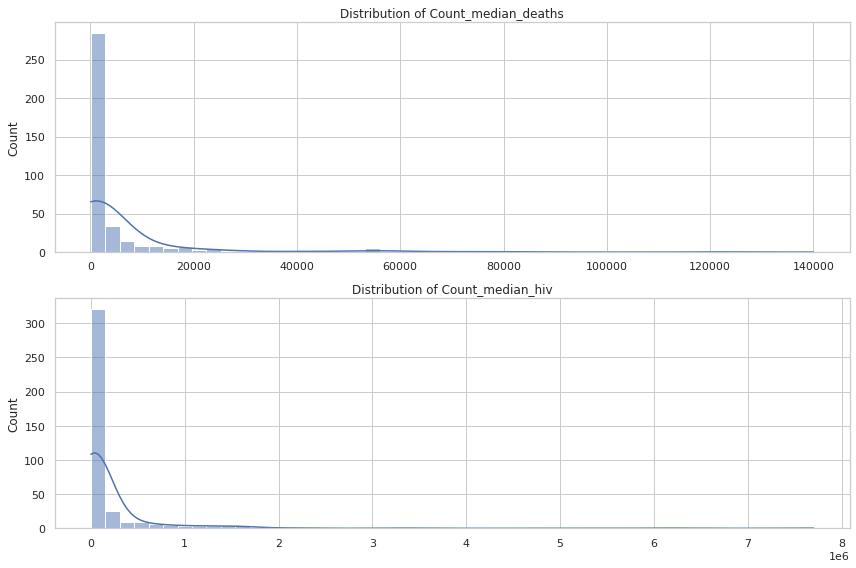

In [11]:
# Collect data from Spark DataFrame to Python list
count_median_deaths_list = filtered_data.select("Count_median_deaths").rdd.flatMap(lambda x: x).collect()
count_median_hiv_list = filtered_data.select("Count_median_hiv").rdd.flatMap(lambda x: x).collect()

# Set style
sns.set(style="whitegrid")

# Create a 2x1 subgraph layout
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Draw the distribution chart of Count_median_deaths
sns.histplot(count_median_deaths_list, kde=True, ax=axes[0], bins=50)
axes[0].set_title('Distribution of Count_median_deaths')

# Draw the distribution graph of Count_median_hiv
sns.histplot(count_median_hiv_list, kde=True, ax=axes[1], bins=50)
axes[1].set_title('Distribution of Count_median_hiv')

# Adjust sub-picture layout
plt.tight_layout()

plt.show()

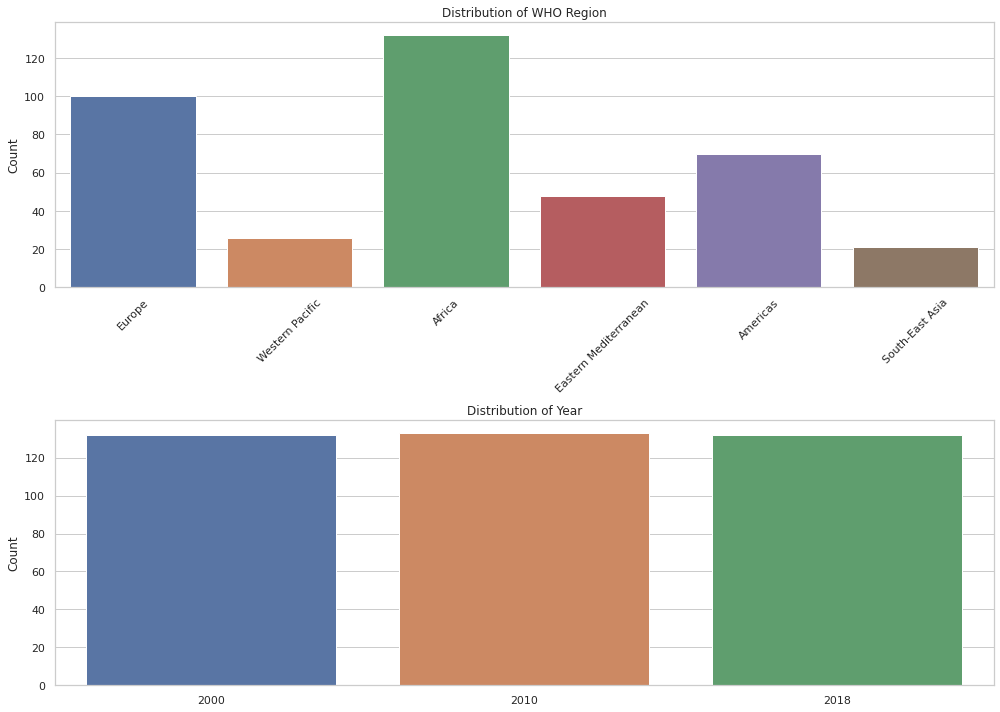

In [12]:
# Calculate the distribution of "WHO Region"
who_region_distribution = filtered_data.groupBy("WHO Region").count().collect()
who_regions = [row["WHO Region"] for row in who_region_distribution]
who_region_counts = [row["count"] for row in who_region_distribution]

# Calculate the distribution of "Year"
year_distribution = filtered_data.groupBy("Year").count().orderBy("Year").collect()
years = [row["Year"] for row in year_distribution]
year_counts = [row["count"] for row in year_distribution]

# Create a 2x1 subplot layout
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Draw a histogram of "WHO Region"
sns.barplot(x=who_regions, y=who_region_counts, ax=axes[0])
axes[0].set_title('Distribution of WHO Region')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Draw a histogram of "Year"
sns.barplot(x=years, y=year_counts, ax=axes[1])
axes[1].set_title('Distribution of Year')
axes[1].set_ylabel('Count')

# Adjust subplot layout
plt.tight_layout()

plt.show()

#### 3.5. Add log-transformed columns to the filtered_data DataFrame

In [13]:
filtered_data = filtered_data.withColumn('Log_Count_median_deaths', log1p(col('Count_median_deaths')))
filtered_data = filtered_data.withColumn('Log_Count_median_hiv', log1p(col('Count_median_hiv')))

# Check data format
print(filtered_data.dtypes)

[('Country', 'string'), ('Year', 'int'), ('Count_deaths', 'string'), ('Count_median_deaths', 'double'), ('Count_hiv', 'string'), ('Count_median_hiv', 'int'), ('WHO Region', 'string'), ('Log_Count_median_deaths', 'double'), ('Log_Count_median_hiv', 'double')]


#### 3.6. Draw comparison charts

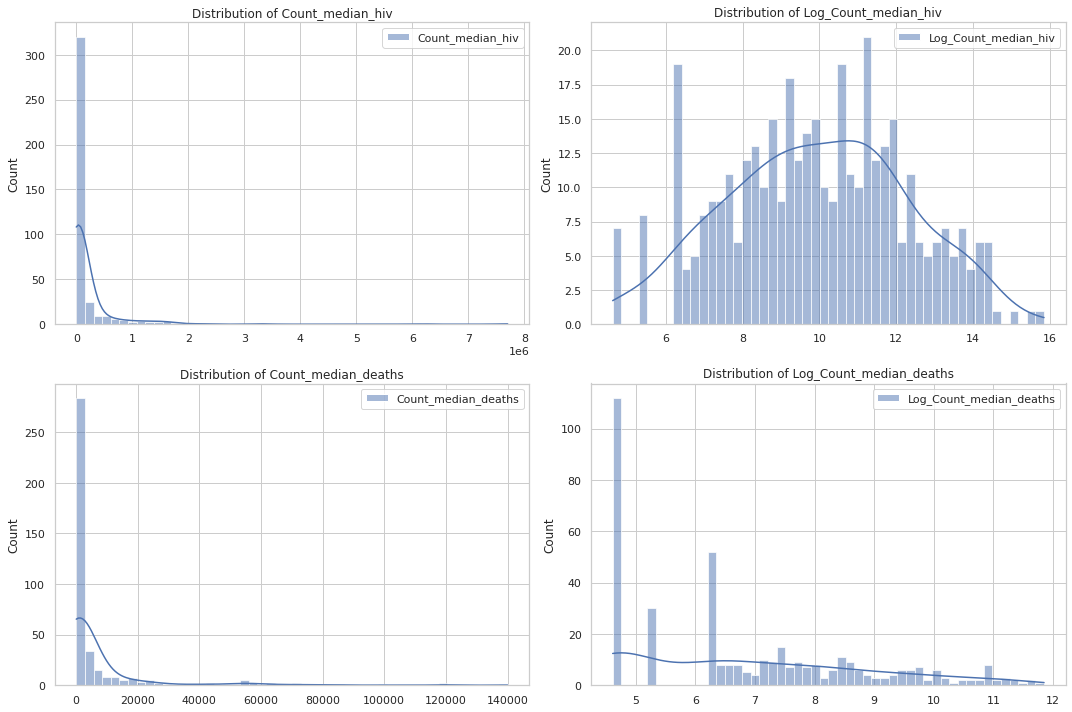

In [14]:
#  Draw a distribution map
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Count_median_hiv 
sns.histplot(filtered_data.select('Count_median_hiv').toPandas(), kde=True, bins=50, ax=axes[0,0], color='blue')
axes[0,0].set_title('Distribution of Count_median_hiv')

# Log_Count_median_hiv 
sns.histplot(filtered_data.select('Log_Count_median_hiv').toPandas(), kde=True, bins=50, ax=axes[0,1], color='red')
axes[0,1].set_title('Distribution of Log_Count_median_hiv')

# Count_median_deaths 
sns.histplot(filtered_data.select('Count_median_deaths').toPandas(), kde=True, bins=50, ax=axes[1,0], color='blue')
axes[1,0].set_title('Distribution of Count_median_deaths')

# Log_Count_median_deaths 
sns.histplot(filtered_data.select('Log_Count_median_deaths').toPandas(), kde=True, bins=50, ax=axes[1,1], color='red')
axes[1,1].set_title('Distribution of Log_Count_median_deaths')

plt.tight_layout()
plt.show()

### 4. Create models

#### 4.1. Reselect the data

In [15]:
data_for_modeling = filtered_data.drop('Count_hiv', 'Count_deaths', 'Count_median_hiv', 'Count_median_deaths')

In [16]:
# Convert 'WHO Region' and 'Country' to categorical variables

# Convert string column to index using StringIndexer
country_indexer = StringIndexer(inputCol="Country", outputCol="CountryIndex")
region_indexer = StringIndexer(inputCol="WHO Region", outputCol="RegionIndex")

# One-hot encoding using OneHotEncoder
data_for_modeling = country_indexer.fit(data_for_modeling).transform(data_for_modeling)
data_for_modeling = region_indexer.fit(data_for_modeling).transform(data_for_modeling)

# Apply transformation
country_encoder = OneHotEncoder(inputCol="CountryIndex", outputCol="CountryVec").fit(data_for_modeling)
region_encoder = OneHotEncoder(inputCol="RegionIndex", outputCol="RegionVec").fit(data_for_modeling)

data_for_modeling = country_encoder.transform(data_for_modeling)
data_for_modeling = region_encoder.transform(data_for_modeling)

# Remove middle columns that are no longer needed
data_for_modeling = data_for_modeling.drop('Country', 'WHO Region', 'CountryIndex', 'RegionIndex')

data_for_modeling.show()

+----+-----------------------+--------------------+---------------+-------------+
|Year|Log_Count_median_deaths|Log_Count_median_hiv|     CountryVec|    RegionVec|
+----+-----------------------+--------------------+---------------+-------------+
|2000|       4.61512051684126|  7.3783837129967145|(133,[0],[1.0])|(5,[3],[1.0])|
|2010|     6.2166061010848646|   8.343077871169383|(133,[0],[1.0])|(5,[3],[1.0])|
|2018|     6.2166061010848646|   8.881975184248867|(133,[0],[1.0])|(5,[3],[1.0])|
|2000|       4.61512051684126|   7.550135342488429|(133,[1],[1.0])|(5,[0],[1.0])|
|2010|      5.303304908059076|   8.867990898182093|(133,[1],[1.0])|(5,[0],[1.0])|
|2018|      5.303304908059076|   9.680406499268875|(133,[1],[1.0])|(5,[0],[1.0])|
|2000|      8.476579508530941|  11.373674891823535|(133,[2],[1.0])|(5,[0],[1.0])|
|2010|      9.210440366976517|  12.301387370778713|(133,[2],[1.0])|(5,[0],[1.0])|
|2018|      9.546884034617925|  12.706850963741102|(133,[2],[1.0])|(5,[0],[1.0])|
|2000|      7.24

### 5. Linear model

In [17]:
# Setting features for the model
feature_columns = ["Year", "CountryVec", "RegionVec", "Log_Count_median_deaths"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="assembled_features")
data_for_modeling = assembler.transform(data_for_modeling)

# Splitting the data
(training_data, test_data) = data_for_modeling.randomSplit([0.7, 0.3], seed=123)

# Defining and training the linear regression model with 'normal' solver
lr = LinearRegression(featuresCol='assembled_features', labelCol='Log_Count_median_hiv', solver="normal")
lr_model = lr.fit(training_data)

# Making predictions
predictions = lr_model.transform(test_data)

23/10/09 13:30:06 WARN Instrumentation: [d8c2862a] regParam is zero, which might cause numerical instability and overfitting.
23/10/09 13:30:06 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/09 13:30:06 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/10/09 13:30:06 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
23/10/09 13:30:06 WARN Instrumentation: [d8c2862a] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
23/10/09 13:30:06 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
23/10/09 13:30:06 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


In [18]:
# Evaluating the model
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Log_Count_median_hiv", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R2:", r2)

evaluator.setMetricName("rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

evaluator.setMetricName("mae")
mae = evaluator.evaluate(predictions)
print("Mean Absolute Error (MAE):", mae)

# Displaying training summary
training_summary = lr_model.summary
print("Num iterations:", training_summary.totalIterations)
print("Objective history:", training_summary.objectiveHistory)

# Accessing coefficient and intercept
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)

R2: 0.9527461930717098
Root Mean Squared Error (RMSE): 0.5016337342703275
Mean Absolute Error (MAE): 0.3986302593484863
Num iterations: 38
Objective history: [0.4999999999999982, 0.30236826881493073, 0.020790574076521295, 0.010298533467738125, 0.005648538139281456, 0.005249639388985372, 0.005097242893231879, 0.005037173670947581, 0.00494429193485324, 0.00431125139362365, 0.004251539946423577, 0.004056937168172681, 0.004047998790067453, 0.00404612947924754, 0.004043652341799486, 0.004036216689121019, 0.004023500851882744, 0.004014987487153121, 0.003998807210148669, 0.003993369417660375, 0.003992754368102425, 0.0039927044862810845, 0.003992692163070188, 0.003992690753912953, 0.003992690386318998, 0.003992690363247675, 0.003992690301325652, 0.003992690207990535, 0.00399269008673464, 0.003992690072978533, 0.00399269002126168, 0.003992690012536215, 0.003992690011871858, 0.003992690011768829, 0.003992690011470401, 0.003992690011374478, 0.00399269001105651, 0.00399269001105651, 0.003992690011

In [19]:
# Use model predictions
predictions = lr_model.transform(test_data)

residuals = predictions.select("Log_Count_median_hiv", "prediction").rdd \
    .map(lambda row: (row[0], row[1], row[0] - row[1])) \
    .collect()

observed = [x[0] for x in residuals]
predicted = [x[1] for x in residuals]
residual_values = [x[2] for x in residuals]

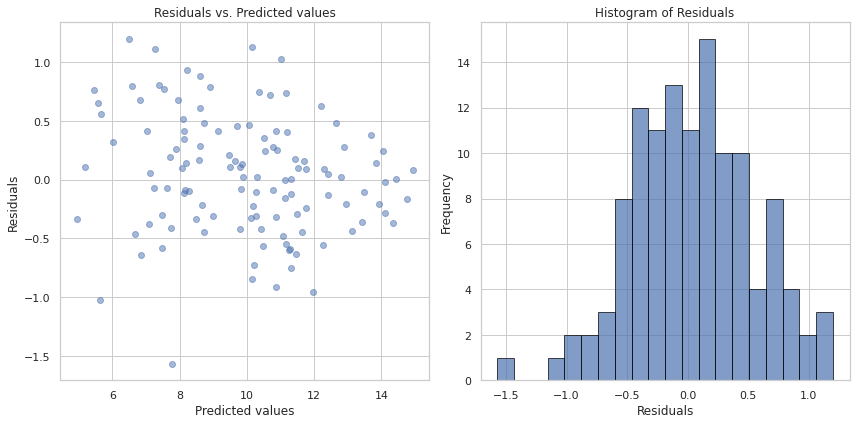

In [20]:
# Plot residuals
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(predicted, residual_values, alpha=0.5)
plt.title("Residuals vs. Predicted values")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")

plt.subplot(1, 2, 2)
plt.hist(residual_values, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [21]:
# Use additional metrics to validate the model's predictive power
mse = np.mean([(x[0] - x[1])**2 for x in residuals])
rmse = np.sqrt(mse)
mae = np.mean([abs(x[0] - x[1]) for x in residuals])

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.25163640335799375
Root Mean Squared Error (RMSE): 0.5016337342703278
Mean Absolute Error (MAE): 0.3986302593484864


### 6. C&R Tree

In [22]:
# Using the previously transformed dataset
data_model = data_for_modeling

# Splitting the data
(training_data, test_data) = data_model.randomSplit([0.7, 0.3], seed=123)

# Features for the model
feature_columns = ["Log_Count_median_deaths", "CountryVec", "RegionVec"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

training_data = assembler.transform(training_data)
test_data = assembler.transform(test_data)

# Building the model
tree_model = DecisionTreeRegressor(featuresCol="features", labelCol="Log_Count_median_hiv")
model = tree_model.fit(training_data)

# Making predictions
train_predictions = model.transform(training_data)
test_predictions = model.transform(test_data)

In [23]:
# Evaluation the model performance
evaluator = RegressionEvaluator(labelCol="Log_Count_median_hiv", predictionCol="prediction", metricName="mse")

train_mse = evaluator.evaluate(train_predictions)
test_mse = evaluator.evaluate(test_predictions)

print("\nModel Performance:")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")

# Retrieve feature importances and other metrics from the model:
print("\nFeature Importances:")
print(model.featureImportances)


Model Performance:
Train MSE: 0.4470
Test MSE: 0.6593

Feature Importances:
(139,[0,15,26,43,46,50,66,68,79,89,106,108,112,137],[0.9530594486314738,0.006492981917502185,0.008284058045835749,0.0018054429034793048,0.005920406057484407,0.0033587430428540814,0.007057589040761062,0.0005788053242249195,0.0012063604364943084,0.0005897433678491856,0.0008545047791743179,0.003536409908484663,0.0048066831082166995,0.0024488234361651202])


In [24]:
# Use the model to make predictions on the test set
test_predictions_with_residuals = test_predictions.withColumn("residual", test_predictions["Log_Count_median_hiv"] - test_predictions["prediction"])

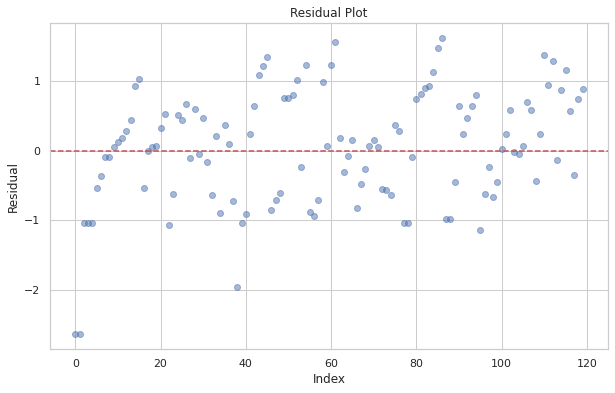

In [25]:
residuals = test_predictions_with_residuals.select("residual").rdd.flatMap(lambda x: x).collect()

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(residuals)), residuals, alpha=0.5)
plt.title("Residual Plot")
plt.xlabel("Index")
plt.ylabel("Residual")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [26]:
# Use MAE, MSE and RMSE to measure the predictive ability of the model
evaluator_mae = RegressionEvaluator(labelCol="Log_Count_median_hiv", predictionCol="prediction", metricName="mae")
evaluator_mse = RegressionEvaluator(labelCol="Log_Count_median_hiv", predictionCol="prediction", metricName="mse")
evaluator_rmse = RegressionEvaluator(labelCol="Log_Count_median_hiv", predictionCol="prediction", metricName="rmse")

mae = evaluator_mae.evaluate(predictions)
mse = evaluator_mse.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.3986302593484863
Mean Squared Error (MSE): 0.2516364033579936
Root Mean Squared Error (RMSE): 0.5016337342703275


### 7. Random Forest

In [27]:
# Building the RandomForest model
rf = RandomForestRegressor(featuresCol="features", labelCol="Log_Count_median_hiv", numTrees=100)
rf_model = rf.fit(training_data)

# Making predictions
train_predictions = rf_model.transform(training_data)
test_predictions = rf_model.transform(test_data)

In [28]:
# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Log_Count_median_hiv", predictionCol="prediction", metricName="mse")
train_mse = evaluator.evaluate(train_predictions)
test_mse = evaluator.evaluate(test_predictions)

train_r2 = evaluator.setMetricName("r2").evaluate(train_predictions)
test_r2 = evaluator.setMetricName("r2").evaluate(test_predictions)

# Print model performance
print("\nModel Performance:")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Train R^2: {train_r2:.4f}")
print(f"Test R^2: {test_r2:.4f}")

# Feature Importances
print("\nFeature Importances:")
for feature, importance in zip(feature_columns, rf_model.featureImportances):
    print(f"{feature}: {importance:.4f}")


Model Performance:
Train MSE: 0.5726
Test MSE: 0.7187
Train R^2: 0.8989
Test R^2: 0.8650

Feature Importances:
Log_Count_median_deaths: 0.6953
CountryVec: 0.0001
RegionVec: 0.0024


In [29]:
# Calculate residuals
test_predictions = test_predictions.withColumn("residual", col("Log_Count_median_hiv") - col("prediction"))

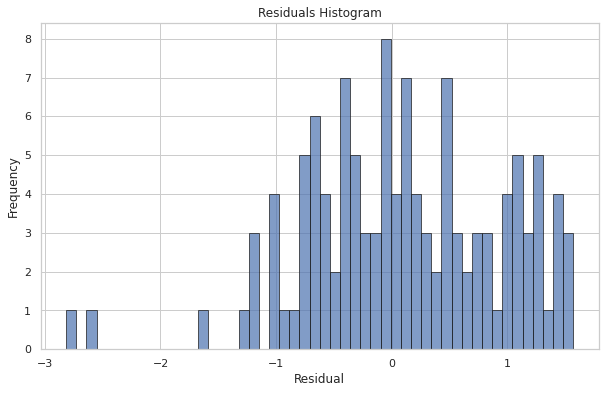

In [30]:
# Plot the residuals
residuals = test_predictions.select("residual").rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title('Residuals Histogram')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [31]:
# Use MAE, MSE and RMSE to measure the predictive ability of the model
evaluator = RegressionEvaluator(labelCol="Log_Count_median_hiv", predictionCol="prediction")

mae = evaluator.evaluate(test_predictions, {evaluator.metricName: "mae"})
mse = evaluator.evaluate(test_predictions, {evaluator.metricName: "mse"})
rmse = evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"})

print("Model Performance on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Model Performance on Test Set:
Mean Absolute Error (MAE): 0.6753
Mean Squared Error (MSE): 0.7187
Root Mean Squared Error (RMSE): 0.8478


### 8.  Visulaize the data

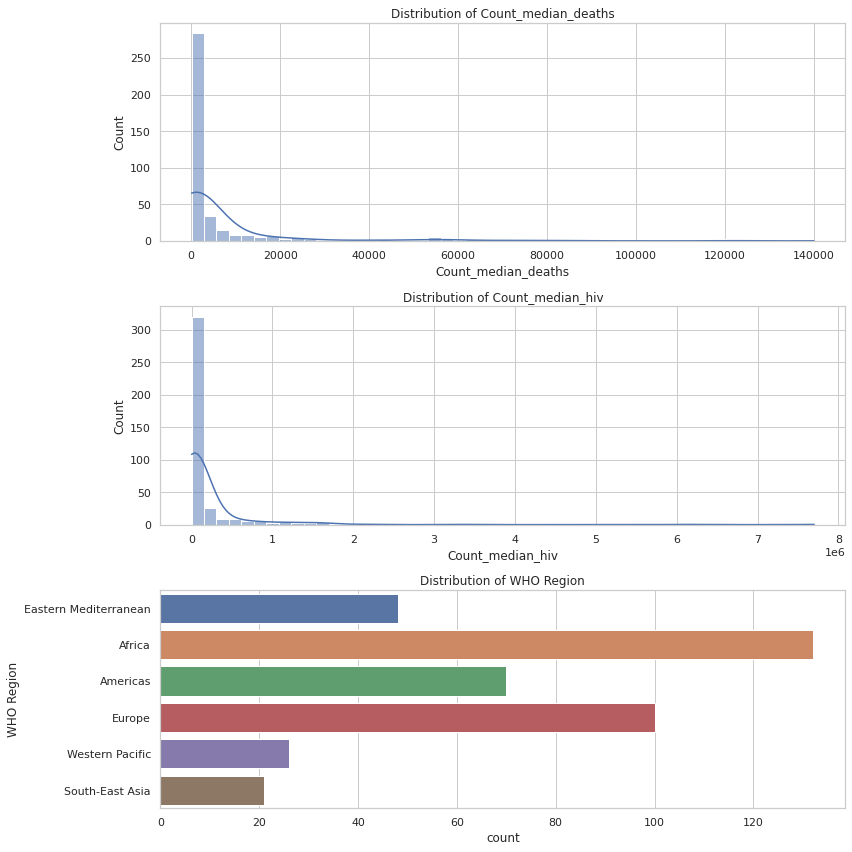

In [32]:
# Convert the Spark DataFrame to Pandas DataFrame for visualization
filtered_data_pd = filtered_data.toPandas()

# Set style for the plots
sns.set(style="whitegrid")

# Create a multi-subplot layout
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Draw the distribution chart of Count_median_deaths
sns.histplot(filtered_data_pd['Count_median_deaths'], kde=True, ax=axes[0], bins=50)
axes[0].set_title('Distribution of Count_median_deaths')

# Draw the distribution graph of Count_median_hiv
sns.histplot(filtered_data_pd['Count_median_hiv'], kde=True, ax=axes[1], bins=50)
axes[1].set_title('Distribution of Count_median_hiv')

# Draw the distribution graph of WHO Region_hiv
sns.countplot(data=filtered_data_pd, y='WHO Region', ax=axes[2])
axes[2].set_title('Distribution of WHO Region')

# Adjust sub-picture layout
plt.tight_layout()
plt.show()


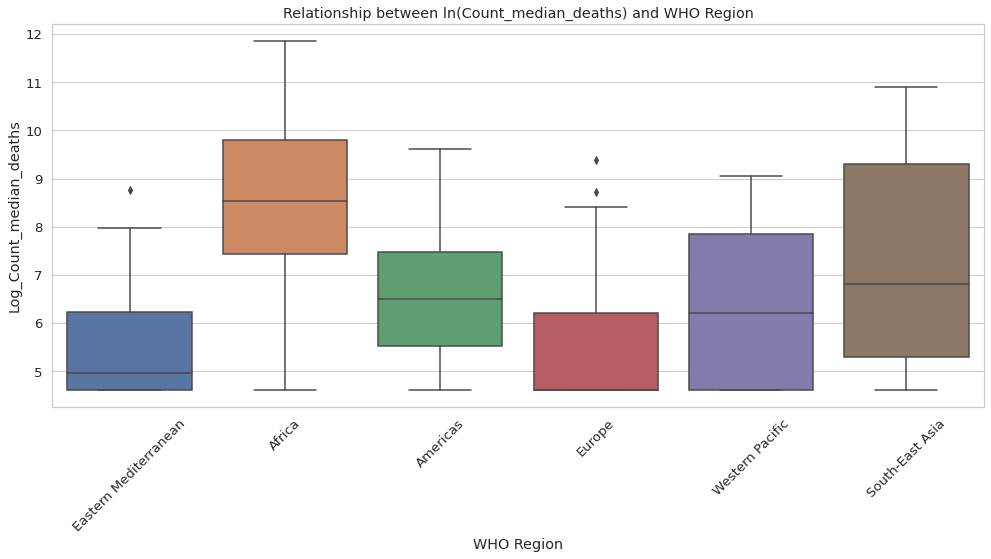

In [33]:
# Set style for the plot
sns.set(style="whitegrid", font_scale=1.2)

# Create a boxplot to visualize the relationship
plt.figure(figsize=(14, 8))
sns.boxplot(x='WHO Region', y='Log_Count_median_deaths', data=filtered_data_pd)

plt.title('Relationship between ln(Count_median_deaths) and WHO Region')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

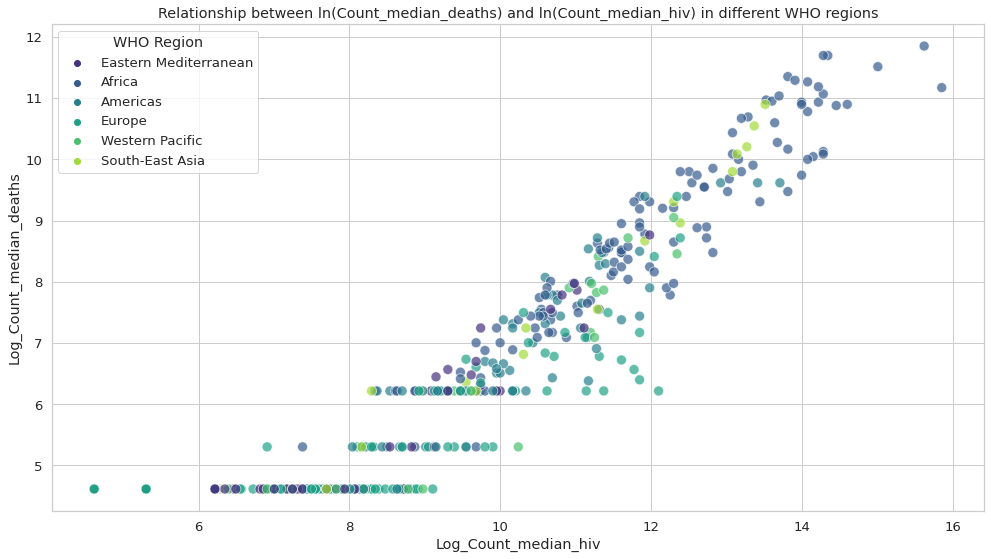

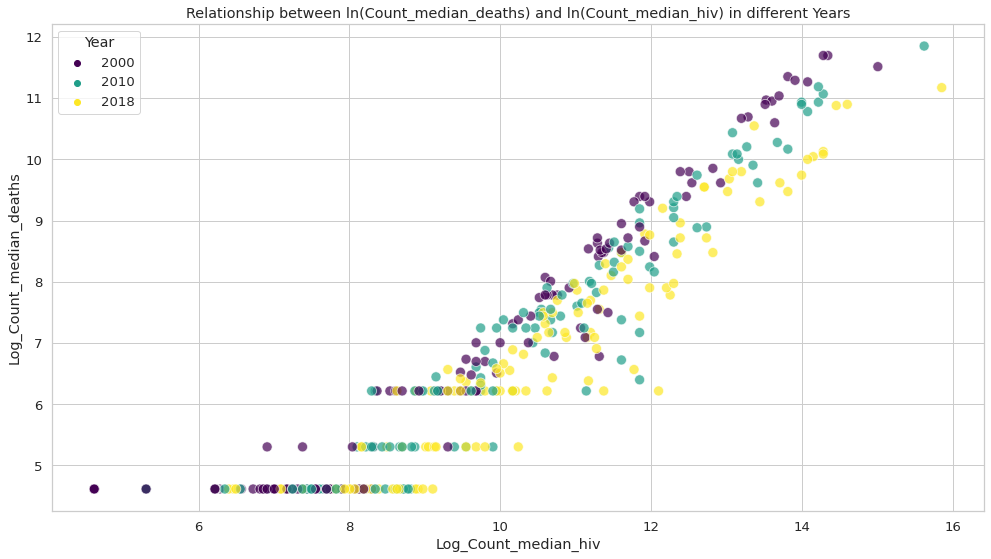

In [34]:
# Set style for the plot
sns.set(style="whitegrid", font_scale=1.2)

# Create a scatter plot to visualize the relationship, colored by WHO Region
plt.figure(figsize=(14, 8))
sns.scatterplot(x='Log_Count_median_hiv', y='Log_Count_median_deaths', hue='WHO Region', data=filtered_data_pd, palette='viridis', s=100, alpha=0.7)

plt.title('Relationship between ln(Count_median_deaths) and ln(Count_median_hiv) in different WHO regions')
plt.tight_layout()
plt.show()

# Set style for the plot
sns.set(style="whitegrid", font_scale=1.2)

# Create a scatter plot to visualize the relationship, colored by Year
plt.figure(figsize=(14, 8))
sns.scatterplot(x='Log_Count_median_hiv', y='Log_Count_median_deaths', hue='Year', data=filtered_data_pd, palette='viridis', s=100, alpha=0.7)

plt.title('Relationship between ln(Count_median_deaths) and ln(Count_median_hiv) in different Years')
plt.tight_layout()
plt.show()

### 9. Optimizing Random Forest model

In [37]:
# Splitting the data
(training_data, test_data) = data_model.randomSplit([0.8, 0.2], seed=123)

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="Log_Count_median_hiv", predictionCol="prediction", metricName="mse")

best_model = None
best_mse = float('inf')

for num_trees in [50, 100]:
    for depth in [5, 10]:
        # Building the RandomForest model with adjusted parameters
        rf = RandomForestRegressor(featuresCol="assembled_features", labelCol="Log_Count_median_hiv", numTrees=num_trees, maxDepth=depth)
        rf_model = rf.fit(training_data)

        # Making predictions on the validation set
        val_predictions = rf_model.transform(test_data)
        mse = evaluator.evaluate(val_predictions)

        # Check if this is the best model so far
        if mse < best_mse:
            best_mse = mse
            best_model = rf_model
        print(f"Num Trees: {num_trees}, Max Depth: {depth}, Validation MSE: {mse:.4f}")

Num Trees: 50, Max Depth: 5, Validation MSE: 0.8730


23/10/09 13:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1189.5 KiB


Num Trees: 50, Max Depth: 10, Validation MSE: 0.4568
Num Trees: 100, Max Depth: 5, Validation MSE: 0.8135


23/10/09 13:37:17 WARN DAGScheduler: Broadcasting large task binary with size 1153.2 KiB
23/10/09 13:37:18 WARN DAGScheduler: Broadcasting large task binary with size 1504.9 KiB
23/10/09 13:37:19 WARN DAGScheduler: Broadcasting large task binary with size 1860.6 KiB
23/10/09 13:37:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


Num Trees: 100, Max Depth: 10, Validation MSE: 0.4749


In [38]:
# Using the best model parameters
rf_best = RandomForestRegressor(featuresCol="assembled_features", labelCol="Log_Count_median_hiv", numTrees=50, maxDepth=10)
best_model = rf_best.fit(training_data)

# Making predictions using the best model
test_predictions = best_model.transform(test_data)

# Evaluate the model's performance on test data
mse = evaluator.evaluate(test_predictions)
evaluator.setMetricName("r2")
r2 = evaluator.evaluate(test_predictions)

print(f"Best Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R^2: {r2:.4f}")

# Display feature importances
feature_importances = best_model.featureImportances
print("\nFeature Importances:")
for feature, importance in zip(feature_columns, feature_importances):
    print(f"{feature}: {importance:.4f}")

23/10/09 13:38:41 WARN DAGScheduler: Broadcasting large task binary with size 1189.5 KiB


Best Model Performance on Test Set:
Mean Squared Error (MSE): 0.4568
R^2: 0.9213

Feature Importances:
Log_Count_median_deaths: 0.0189
CountryVec: 0.0004
RegionVec: 0.0042


In [39]:
# Calculate residuals
test_predictions = test_predictions.withColumn("residual", col("Log_Count_median_hiv") - col("prediction"))

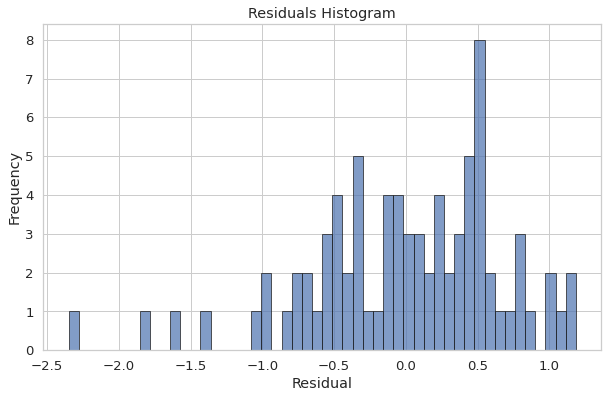

In [40]:
# Plot the residuals
residuals = test_predictions.select("residual").rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title('Residuals Histogram')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [41]:
# Use MAE, MSE and RMSE to measure the predictive ability of the model
mae = evaluator.setMetricName("mae").evaluate(test_predictions)
mse = evaluator.setMetricName("mse").evaluate(test_predictions)
rmse = evaluator.setMetricName("rmse").evaluate(test_predictions)

print("Model Performance on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Model Performance on Test Set:
Mean Absolute Error (MAE): 0.5316
Mean Squared Error (MSE): 0.4568
Root Mean Squared Error (RMSE): 0.6759
